In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import sys
import time
import pickle

from moviepy.editor import VideoFileClip

from IPython.display import HTML

from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.cross_validation import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Drawing bounding boxes

In [2]:
def draw_boxes(img, boxes, color=(0, 0, 255), thick=6):
    """Draws bounding boxes on an image."""
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in boxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# Features

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def hog_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features_set(list_images_set, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
    data_features = []
    for each_path in list_images_set:
        img = cv2.imread(each_path)
        data_features.append(hog_features(img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat))
    return data_features

# SVM

In [4]:
# function to get a set of features and put them into a list
def extract_features(list_images_set, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
    data_features = []
    for each_path in list_images_set:
        img = cv2.imread(each_path)
        data_features.append(hog_features(img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat))
    return data_features


# function to prepare dataset, it returns the features and the labels
def get_data(vehicle_path, non_vehicle_path, take_pos = 0, take_neg = 0):
    x_data = []
    y_data = []
    x_data_car = []
    y_data_car = []
    x_data_nocar = []
    y_data_nocar = []
    im_v = glob.glob(vehicle_path + '/*')
    list_path_images = []
    for each_folder in im_v:
        im_list = glob.glob(each_folder + '/*')
        list_path_images = list_path_images + list(im_list)
        
    for each_path in list_path_images:
        #img = cv2.imread(each_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img_feature = single_img_features(img)
        #x_data_car.append(img_feature)
        x_data_car.append(each_path)
        y_data_car.append(1)
    
    im_nv = glob.glob(non_vehicle_path + '/*')
    list_path_images = []
    for each_folder in im_nv:
        im_list = glob.glob(each_folder + '/*')
        list_path_images = list_path_images + list(im_list)
    for each_path in list_path_images:
        #img = cv2.imread(each_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img_feature = single_img_features(img)
        #x_data_nocar.append(img_feature)
        x_data_nocar.append(each_path)
        y_data_nocar.append(0)


    x_data = x_data_car
    y_data = y_data_car
        
    print('positive', len(x_data))
    

    x_data = x_data + x_data_nocar
    y_data = y_data + y_data_nocar
        
    print('positive + negative', len(x_data))
    
    return x_data, y_data

def save_svm(model_filename='model.pickle', scaler_filename='scaler.pickle'):
    my_x, my_y = get_data('vehicles/', 'non-vehicles/')
    # extract_features from list of images and these parameters

    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 13  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (8, 8) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    data_feats = extract_features(my_x, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    X_scaler = RobustScaler().fit(data_feats)
    scaled_X = X_scaler.transform(data_feats)
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, my_y, test_size=0.2, random_state=rand_state)

    k=5
    svc = LinearSVC(C=10**k)
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    with open('model.pickle', 'wb') as output:
        pickle.dump(svc, output, pickle.HIGHEST_PROTOCOL)
    
    with open('scaler.pickle', 'wb') as output:
        pickle.dump(X_scaler, output, pickle.HIGHEST_PROTOCOL)

    
    
def get_svm(filename='model.pickle'):
    # SVM classifier
    with open(filename, 'rb') as in_path:
        svc_model = pickle.load(in_path)

    return svc_model

def get_scaler(filename='scaler.pickle'):
    with open(filename, 'rb') as in_path:
        scaler = pickle.load(in_path)
    return scaler

In [5]:
save_svm()
get_svm()

('positive', 8792)
('positive + negative', 17760)
(16.2, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9916)


LinearSVC(C=100000, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [6]:
# Verify it works
import glob
images = glob.glob('test_images/*')
images = sorted(images)

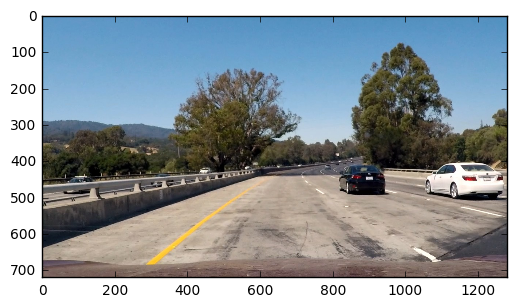

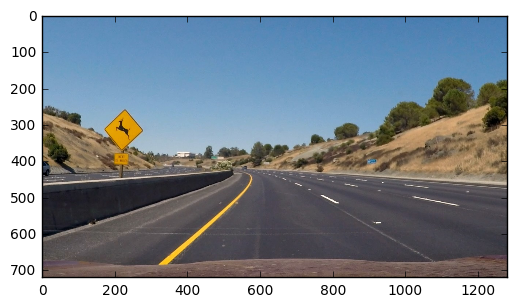

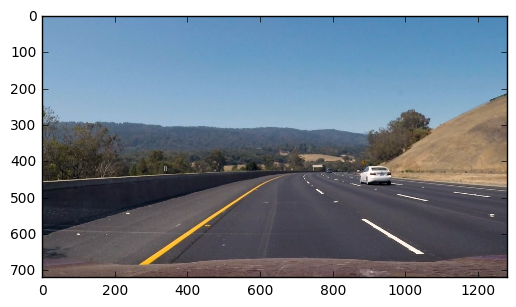

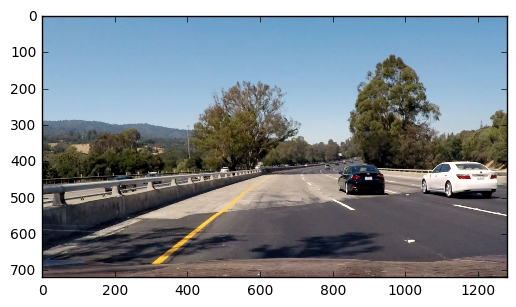

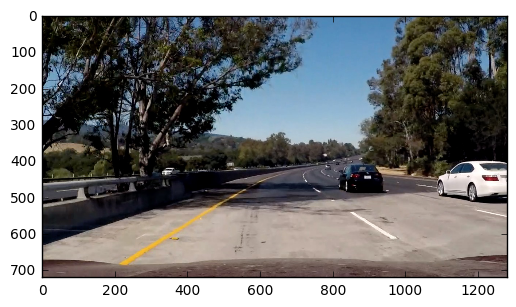

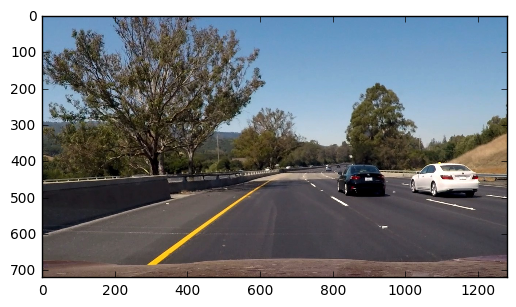

In [7]:
for image in images:
    img_test = cv2.imread(image)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(img_test)

# Windows

In [8]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = hog_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.decision_function(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction > 0.4:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Heatmap

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_heatmap(img, hot_windows):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 10)

    return heat

In [10]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Time filtering

In [11]:
from collections import deque
global boxes_circular_queue


boxes_circular_queue = deque([], maxlen=5)


def temporal_filter(boxes):
    # Do not do any filtering for now
    return boxes
    #boxes_circular_queue.append(boxes)
    #return np.average(boxes_circular_queue, axis=0).astype(int)

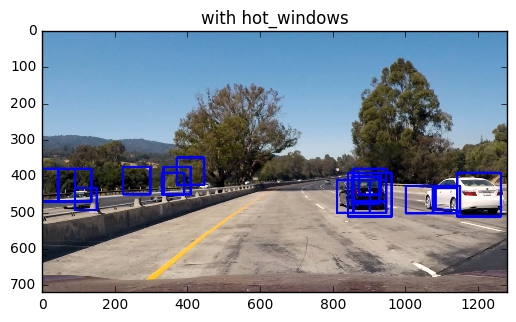

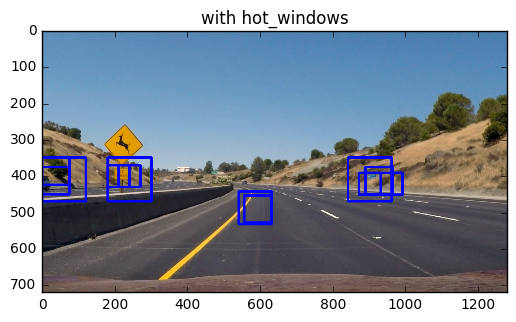

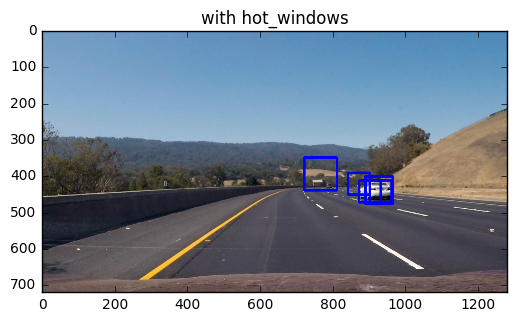

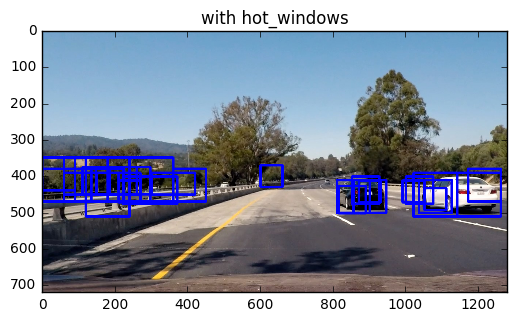

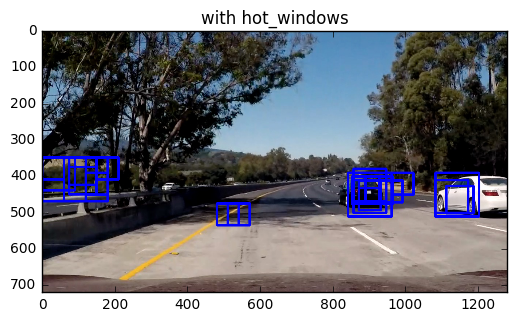

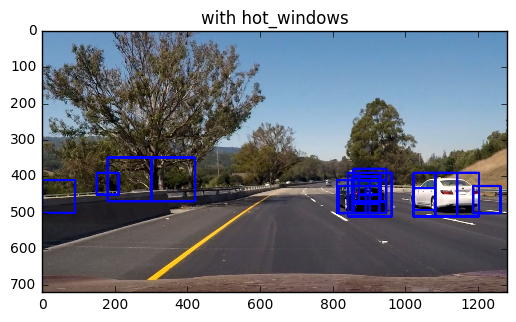

In [12]:
y_start_stop=(350, 550)
x_start_stop=(0, 1300)
xy_window=(64, 64)
xy_overlap=(0.5, 0.65)
scale=1
color_space='YCrCb'
spatial_size=(8, 8)
hist_bins=16
orient=13
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=False
hog_feat=True




for img_path in images:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    svc_model = get_svm()
    scaler = get_scaler()

    hot_windows = []
    
    for window_size in [(60, 60), (75, 75), (90, 90), (120, 120)]:
        
        raw_windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                               xy_window=window_size, xy_overlap=(0.5, 0.65)) 
    

        some_hot_windows = search_windows(img, raw_windows, svc_model, scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        
        hot_windows = hot_windows + some_hot_windows


    with_hot_windows = draw_boxes(img, hot_windows)

    plt.figure()
    plt.title('with hot_windows')
    plt.imshow(with_hot_windows)

In [17]:
def get_contour_params(contour):
    (x_pos, y_pos), radius = cv2.minEnclosingCircle(contour)

    return {
        "center": (int(x_pos), int(y_pos)),
        "radius": radius,
        "area": cv2.contourArea(contour)
    }

In [41]:
fgbg = cv2.createBackgroundSubtractorMOG2()

    
def pipeline(img, y_start_stop=(350, 650), x_start_stop=(600, 1200), xy_window=(96, 96), xy_overlap=(0.1, 0.1), scale=1.4,
             color_space='YCrCb', spatial_size=(8, 8), hist_bins=16, orient=13, pix_per_cell=8,
             cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=False, hog_feat=True,
             background_removal=fgbg): 

    foreground = fgbg.apply(img, learningRate=0.003)
    
    hierarchy, contours, nose = cv2.findContours(foreground.copy(),
                                               mode=cv2.RETR_TREE,
                                               method=cv2.CHAIN_APPROX_SIMPLE)
    raw_windows = []
    for contour in contours:
        contour_params = get_contour_params(contour)
        x, y = contour_params["center"] 
        radius = int(contour_params["radius"])
        window = ((x-radius, y-radius), (x+radius, y+radius))
        raw_windows.append(window)
        
    with_raw_windows = draw_boxes(img, raw_windows)


    """
    
    raw_windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

    svc_model = get_svm()
    scaler = get_scaler()
    
    hot_windows = search_windows(img, raw_windows, svc_model, scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    
    
    with_hot_windows = draw_boxes(img, hot_windows)

    heat = draw_heatmap(img, hot_windows)
        
    # Consider features connected even if they touch diagonally
    s = [[1,1,1],
         [1,1,1],
         [1,1,1]]
    labels = label(heat,  structure=s)
    
    with_labels = draw_labeled_bboxes(np.copy(img), labels)

    time_labels = temporal_filter(labels)

    with_time = draw_labeled_bboxes(np.copy(img), time_labels)

    """
    
    output = np.zeros((1080, 1800, 3), dtype=np.uint8)
    
    output[360:1080, 0:1200] = cv2.resize(img, (1200,720), interpolation=cv2.INTER_AREA) 

    output[0:360, 0:600] = cv2.resize(with_raw_windows, (600,360), interpolation=cv2.INTER_AREA)   

    output[0:360, 600:1200] = cv2.resize(np.dstack((foreground, foreground, foreground)), (600,360), interpolation=cv2.INTER_AREA)

    #output[0:360, 1200:1800] = cv2.resize(np.dstack((heat*20, heat*20, heat*30)), (600,360), interpolation=cv2.INTER_AREA)

    #output[360:720,1200:1800] = cv2.resize(with_labels, (600,360), interpolation=cv2.INTER_AREA) 

    output[720:1080,1200:1800] = cv2.resize(img, (600,360), interpolation=cv2.INTER_AREA) 
    
    return output

In [ ]:
white_output = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4



 44%|████▍     | 554/1261 [15:03<52:58,  4.50s/it]

In [16]:
HTML("""
<video width="900" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [26]:
cv2.VERSION

AttributeError: 'module' object has no attribute 'VERSION'